# 0. Import library


In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns
import warnings
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

# 1. Data Analyzing
🌱 [참고 자료](https://www.kaggle.com/competitions/severstal-steel-defect-detection)

In [2]:
# 코랩에서 구글 드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/"

In [4]:
# 데이터 불러오기
train_df = pd.read_csv(path+"train.csv")

In [ ]:
# 데이터셋 전체 출력을 위한 옵션
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [5]:
train_df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [11]:
train_df.shape

(7095, 3)

In [7]:
# class id에 따른 손상의 종류 개수 파악하기
defect1_count = train_df[train_df['ClassId']==1]['EncodedPixels'].notnull().count()
defect2_count = train_df[train_df['ClassId']==2]['EncodedPixels'].notnull().count()
defect3_count = train_df[train_df['ClassId']==3]['EncodedPixels'].notnull().count()
defect4_count = train_df[train_df['ClassId']==4]['EncodedPixels'].notnull().count()
defect1_count, defect2_count, defect3_count, defect4_count

(897, 247, 5150, 801)

<Axes: >

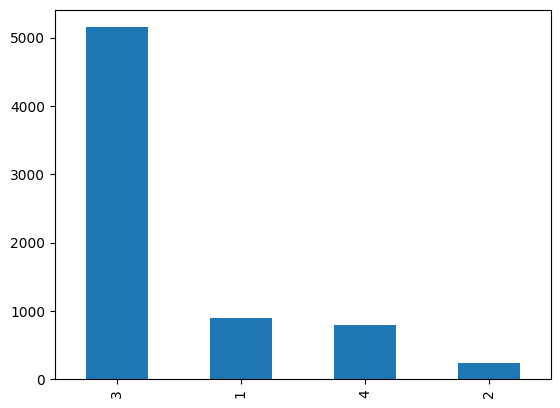

In [10]:
train_df["ClassId"].value_counts().plot(kind = 'bar')

Text(0.5, 1.0, 'Defect Type Ratio')

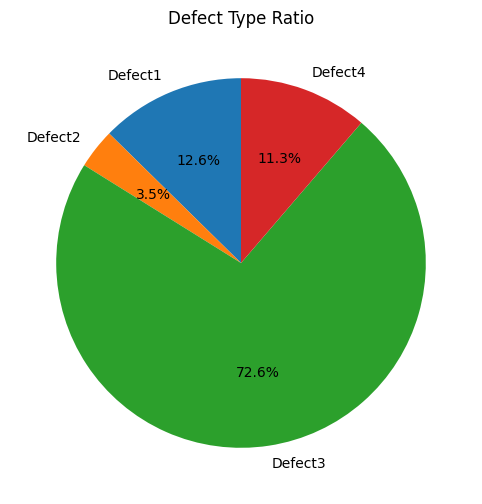

In [ ]:
# 클래스별 개수 이미지로 한눈에 보기
labels = ['Defect1', "Defect2", "Defect3", "Defect4"]
size_data = [defect1_count, defect2_count, defect3_count, defect4_count]
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
options = ax.pie(size_data, labels=labels,autopct="%1.1f%%", startangle=90)
ax.set_title("Defect Type Ratio")

In [ ]:
# 예시 데이터 픽셀 출력
train_df.loc[0]['EncodedPixels']

'29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5'

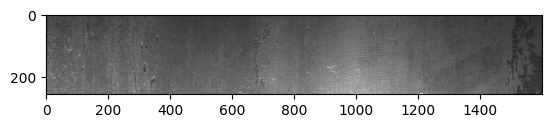

In [ ]:
# 예시 데이터 이미지 출력
plt.imshow(Image.open(path+'train_images/'+train_df.loc[0]['ImageId']));

# 2. Data preprocessing

Image Augmentation

In [13]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(train_df.values):
    image=cv2.imread(path+"train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)


100%|██████████| 7095/7095 [1:47:04<00:00,  1.10it/s]


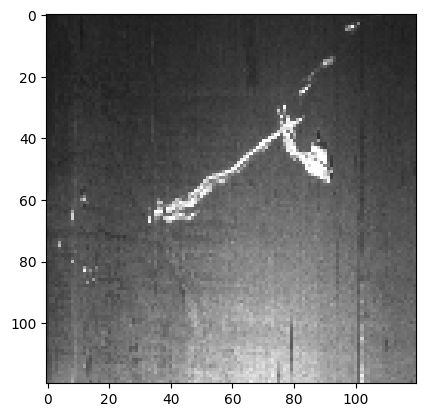

In [14]:
plt.imshow(l1[16])

Label encoding the input features and one hot encoding the target feature.

In [15]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = to_categorical(y)

Splitting the data into 80% train set and 20% test set

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [17]:
print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (5676, 120, 120, 3)
x_test shape: (1419, 120, 120, 3)
y_train shape: (5676, 4)
y_test shape: (1419, 4)


# 3. Training CNN model

[참고 자료](https://www.kaggle.com/code/ratul6/steel-defect-detection-using-cnn) <br>

Building the CNN Model

In [18]:
img_shape = (120,120,3)

# Set up the model
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3), strides=(1, 1), padding="same", activation="relu",input_shape=img_shape))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Compiling the model

In [20]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

Fitting the model

In [21]:
history = model.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1, callbacks=[early_stopping])

Epoch 1/15
45/45 [==============================] - 21s 160ms/step - loss: 0.8975 - accuracy: 0.7082 - val_loss: 0.8094 - val_accuracy: 0.7259
Epoch 2/15
45/45 [==============================] - 4s 82ms/step - loss: 0.7866 - accuracy: 0.7296 - val_loss: 0.7440 - val_accuracy: 0.7519
Epoch 3/15
45/45 [==============================] - 3s 75ms/step - loss: 0.7312 - accuracy: 0.7421 - val_loss: 0.6898 - val_accuracy: 0.7477
Epoch 4/15
45/45 [==============================] - 3s 77ms/step - loss: 0.7019 - accuracy: 0.7438 - val_loss: 0.6376 - val_accuracy: 0.7491
Epoch 5/15
45/45 [==============================] - 3s 61ms/step - loss: 0.6564 - accuracy: 0.7489 - val_loss: 0.6125 - val_accuracy: 0.7611
Epoch 6/15
45/45 [==============================] - 3s 64ms/step - loss: 0.6224 - accuracy: 0.7477 - val_loss: 0.5732 - val_accuracy: 0.7562
Epoch 7/15
45/45 [==============================] - 3s 63ms/step - loss: 0.5852 - accuracy: 0.7560 - val_loss: 0.5939 - val_accuracy: 0.7576
Epoch 8/15


<Axes: title={'center': 'Loss curve'}>

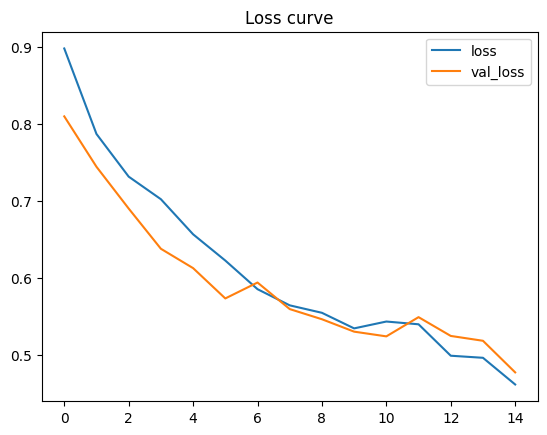

In [22]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

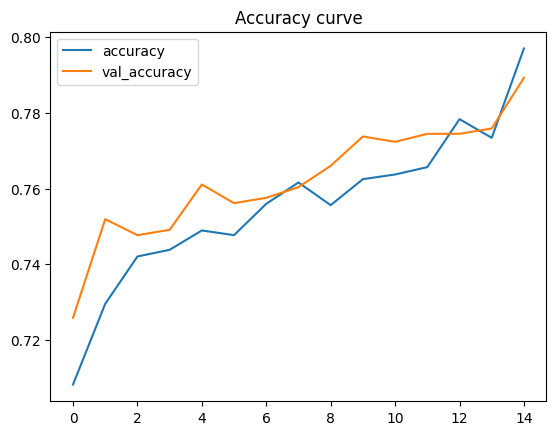

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [24]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

45/45 [==============================] - 0s 7ms/step - loss: 0.4773 - accuracy: 0.7893
[+] Accuracy: 78.93%
